In [88]:
import pandas as pd

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction import stop_words
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn import tree

import nltk
from nltk.corpus import wordnet

from scipy.sparse import hstack

from urlextract import URLExtract

import re

import numpy as np

import pydotplus

from IPython.display import Image

import sys

sys.path.append('..')
from src.features.build_features import syns, sep_urls, check_paren, repo_label

In [2]:
extract = URLExtract()

In [3]:
df = pd.read_csv('/data/riddleta/data_sharing_reuse/external/combined_labels_incomplete.csv')
df.head()

,data_statement,doi,pmcid,section,text,Journal Title,Year,Volume,Issue,Page,PMCID,PMID,cv_run0,cv_run1,cv_run2,cv_run3,cv_run4,cv_sum
0,0,10.1007/s11481-008-9113-7,2581635,DISCUSS,In the Golgi-impregnation experiment we found ...,J Neuroimmune Pharmacol,2008,3,4,241,PMC2581635,18594991,0,0,0,0,0,0
1,0,10.1016/j.biopsych.2008.07.009,2586327,METHODS,The individuals with at least 3 usable voxels ...,Biol Psychiatry,2008,64,10,856,PMC2586327,18707679,0,0,0,0,0,0
2,0,10.1016/j.brainres.2008.07.008,2612637,METHODS,Although our procedure was intended to target ...,Brain Res,2008,1230,NaN,202,PMC2612637,18662678,0,0,0,0,0,0
3,0,10.1371/journal.pone.0004156,2612746,METHODS,"low status face pictures, and included genotyp...",PLoS One,2009,4,1,e4156,PMC2612746,19142220,0,0,0,0,0,0
4,0,10.1016/j.neuron.2008.07.022,2614916,METHODS,"For each word, participants made a recognition...",Neuron,2008,59,4,547,PMC2614916,18760691,0,0,0,0,0,0


In [131]:
df.text.fillna('', inplace=True)
df['has_url'] = df.text.apply(lambda x: extract.has_urls(x))
df['has_parenth'] = df.text.apply(lambda x: check_paren(x))
df['repo'] = df.text.apply(lambda x: repo_label(x))
df['text'] = df.text.apply(lambda x: sep_urls(x))
df['syn_text'] = df.text.apply(lambda x: syns(x))
df['all_text'] = df.text + ' ' + df.syn_text

In [5]:
cv = CountVectorizer(stop_words=stop_words.ENGLISH_STOP_WORDS)
enc = OneHotEncoder(handle_unknown='ignore')

In [6]:
x_tr, x_tst, y_tr, y_tst = train_test_split(df.all_text, df.data_statement, test_size=.25, random_state=42, stratify=df.data_statement)

In [129]:
x_train = cv.fit_transform(x_tr)
one_hots_train = enc.fit_transform(df[['section', 'Journal Title', 'Year', 'has_url', 'has_parenth', 'repo']].loc[x_tr.index])
y_train = df.data_statement[x_tr.index]
x_test = cv.transform(df.all_text[x_tst.index])
one_hots_test = enc.transform(df[['section', 'Journal Title', 'Year', 'has_url', 'has_parenth', 'repo']].iloc[x_tst.index])
y_test = df.data_statement[x_tst.index]

x_train = hstack([x_train, one_hots_train])
x_test = hstack([x_test, one_hots_test])
#x_res, y_res = ros.fit_resample(x_train, y_train)

clf = DecisionTreeClassifier(max_leaf_nodes = 6, random_state=42)
#y_score = clf.fit(x_res, y_res).decision_function(x_test)
y_score = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

x_columns = cv.get_feature_names()
x_columns.extend(enc.get_feature_names())

[[571  10]
 [  9  44]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       581
           1       0.81      0.83      0.82        53

    accuracy                           0.97       634
   macro avg       0.90      0.91      0.90       634
weighted avg       0.97      0.97      0.97       634



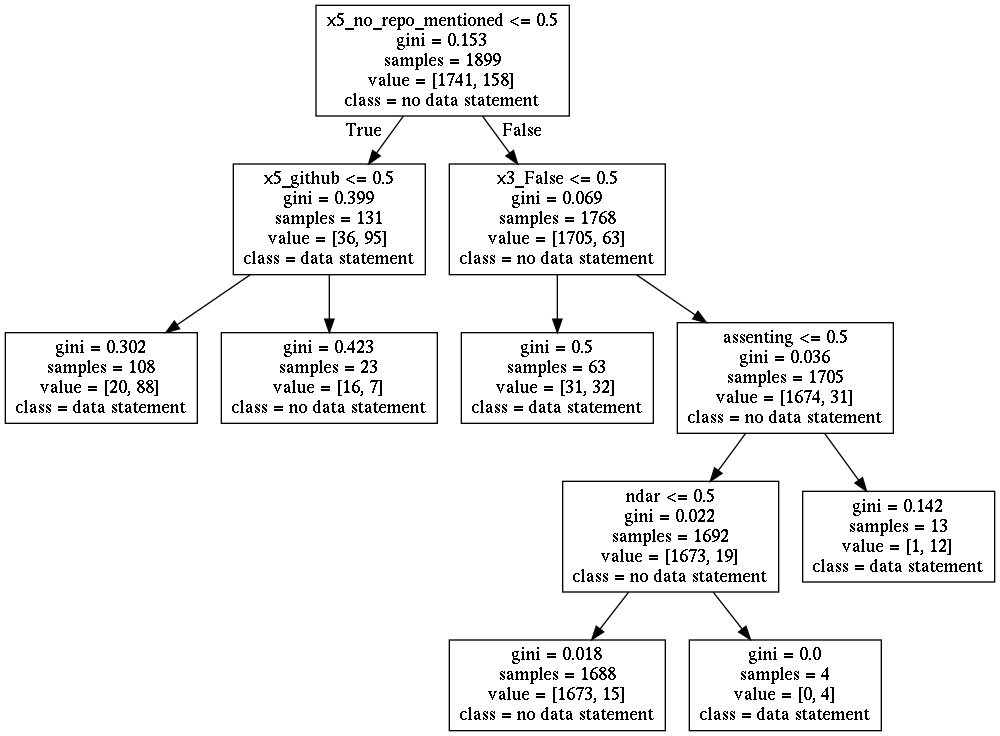

In [130]:
dot_dat = tree.export_graphviz(clf, feature_names=x_columns, class_names=['no data statement', 'data statement'])
graph = pydotplus.graph_from_dot_data(dot_dat)
Image(graph.create_png()) #x3_False refers to the presence of URLs

In [46]:
enc.get_feature_names()

array(['x0_ABBR', 'x0_ABSTRACT', 'x0_ACK_FUND', 'x0_APPENDIX',
       'x0_AUTH_CONT', 'x0_CONCL', 'x0_DISCUSS', 'x0_FIG', 'x0_INTRO',
       'x0_METHODS', 'x0_NONE', 'x0_NOTES', 'x0_REF', 'x0_RESULTS',
       'x0_REVIEW_INFO', 'x0_SUPPL', 'x0_TABLE', 'x1_ACS Chem Biol',
       'x1_ACS Chem Neurosci', 'x1_AIDS', 'x1_AIDS Behav', 'x1_AIDS Care',
       'x1_AIDS Educ Prev', 'x1_AIDS Res Treat', 'x1_Acad Pediatr',
       'x1_Acad Psychiatry', 'x1_Adm Policy Ment Health',
       'x1_Adv Methods Pract Psychol Sci', 'x1_Adv Pharmacol',
       'x1_Adv Sch Ment Health Promot', 'x1_Aggress Behav',
       'x1_Alzheimers Dement', 'x1_Am J Drug Alcohol Abuse',
       'x1_Am J Eval', 'x1_Am J Geriatr Psychiatry',
       'x1_Am J Med Genet B Neuropsychiatr Genet',
       'x1_Am J Psychiatr Rehabil', 'x1_Am J Psychiatry',
       'x1_Am J Public Health', 'x1_Am Psychol', 'x1_Anal Chem',
       'x1_Anim Behav', 'x1_Anim Cogn', 'x1_Ann Appl Stat',
       'x1_Ann Clin Transl Neurol', 'x1_Ann Hum Genet',
 